In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
from importlib import reload
import random
from functools import reduce, partial
from os.path import join
from time import time
import os

from tqdm import tqdm
import pandas as pd
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import pytorch_lightning as pl
import skimage.morphology as morp
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from PIL import Image, ImageDraw
import torchviz
# from deep_morpho.datasets.mnist_dataset import MnistClassifDataset
# from deep_morpho.models import LightningBiMoNNClassifier, BiSE, COBiSE, BiSEC, COBiSEC


import deep_morpho.models.softplus as sfp
import general.array_morphology as arm
import general.structuring_elements as selm
from general.nn.loss import DiceLoss

import deep_morpho.binarization.bise_closest_selem as bcs
import deep_morpho.binarization as binarization

import deep_morpho.initializer.bise_initializer as bise_init
import deep_morpho.initializer.bisel_initializer as bisel_init
import deep_morpho.initializer.bimonn_initializer as bimonn_init
import deep_morpho.initializer as inits

import deep_morpho.loss as dmloss
import deep_morpho.threshold_fn as threshold_fn
import deep_morpho.morp_operations as morpop
import deep_morpho.models.threshold_layer as threshold_layer
import deep_morpho.models.weights_layer as weights_layer
import deep_morpho.models.complementation_layer as complementation_layer
import deep_morpho.models.pconv as pconv
import deep_morpho.models.lightning_pconv as lpconv
import deep_morpho.models.bise_base as bise_base
import deep_morpho.models.bise as bise
import deep_morpho.models.lui as lui
import deep_morpho.models.bisel as bisel
import deep_morpho.models.cobise as cobise
import deep_morpho.models.dilation_sum_layer as dis
import deep_morpho.models.bimonn as bimonn
import deep_morpho.models as models
import deep_morpho.models.lightning_bise as lbise
import deep_morpho.models.lightning_cobise as lcobise
import deep_morpho.models.lightning_bimonn as lbimonn
import deep_morpho.datasets.generate_forms1 as gfo
import deep_morpho.datasets.generate_forms2 as gfo2
import deep_morpho.datasets.generate_forms3 as gfo3
import deep_morpho.datasets.axspa_roi_dataset as axd
import deep_morpho.datasets.diskorect_dataset as mrda
import deep_morpho.datasets.mnist_dataset as mnist_dataset
import deep_morpho.observables.plot_parameters as obs_weights
import deep_morpho.observables.plot_pred as obs_pred
import deep_morpho.observables.weight_histogram as weight_histogram
import deep_morpho.observables as obs
import general.nn.viz.plot_histogram as phist
import general.nn.viz.element_image as eltimage
import general.nn.viz.element_histogram as elthistogram
import deep_morpho.viz.morp_operations_viz as mov
import deep_morpho.viz.elt_generator_bimonn_forward_save as eltgenbifor
import deep_morpho.viz.elt_generator_bimonn_histogram as eltgenbihist
import deep_morpho.viz.bimonn_viz as bimonn_viz

import deep_morpho.biblio_comparison.original_models.models.smorph as ori_smorph
import deep_morpho.biblio_comparison.models as bib_models

def reload_modules():
    for modl in [bcs, binarization, bise_init, bisel_init, bimonn_init, inits, sfp, arm, dmloss, selm, threshold_fn, morpop,
                 threshold_layer, weights_layer, complementation_layer, pconv, lpconv, bise_base, bise, lui, bisel, cobise,
                 dis, bimonn, models, lbise, lbimonn, lcobise, gfo, gfo2, gfo3, axd,
                 mrda, mnist_dataset, obs_weights, obs_pred, obs,
                weight_histogram, phist, eltimage, elthistogram, mov, eltgenbifor, eltgenbihist, bimonn_viz,
                ori_smorph, bib_models]:
        reload(modl)
        
reload_modules()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

ModuleNotFoundError: No module named 'deep_morpho.models.cobise'

In [74]:
model_ori = ori_smorph.SMorph(in_channels=1, out_channels=1, filter_size=7)
model_rec = bib_models.SMorph(kernel_size=(7, 7))

# model_rec.weights.data = torch.ones(7, 7)
model_ori.filter.data = model_rec.weights[None, None, ...]

In [78]:
x = torch.rand(1, 1, 50, 50)
ot_rec = model_rec(x)
ot_ori = model_ori(x)

print((ot_rec - ot_ori).abs().mean())
print((ot_rec[3:-3, -3:3] - ot_ori[3:-3, -3:3]).abs().sum())

tensor(0.0319, grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<SumBackward0>)


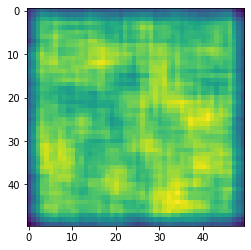

In [79]:
plt.imshow(ot_rec.squeeze().detach())

In [66]:
print(ot_rec.unique(return_counts=True))
print(ot_ori.unique(return_counts=True))


(tensor([1.1404, 1.1575, 1.1813,  ..., 1.6210, 1.6304, 1.6307],
       grad_fn=<Unique2Backward0>), tensor([1, 1, 1,  ..., 1, 1, 1]))
(tensor([1.3800, 1.3843, 1.3864,  ..., 1.6610, 1.6627, 1.6876],
       grad_fn=<Unique2Backward0>), tensor([1, 1, 1,  ..., 1, 1, 1]))


In [62]:
print(output.unique(return_counts=True))
print(ot_ori.unique(return_counts=True))


(tensor([1.3265, 1.4082, 1.4898, 1.5102, 1.5714, 1.6122, 1.7143, 1.7347, 1.8571,
        2.0000], grad_fn=<Unique2Backward0>), tensor([   4,    8,    8,    4,  176,    8,  176,    4,  176, 1936]))
(tensor([2.], grad_fn=<Unique2Backward0>), tensor([2500]))


In [ ]:
ot_rec[]

In [46]:
ot_rec

tensor([[[[1.3265, 1.4082, 1.4898,  ..., 1.4898, 1.4082, 1.3265],
          [1.4082, 1.5102, 1.6122,  ..., 1.6122, 1.5102, 1.4082],
          [1.4898, 1.6122, 1.7347,  ..., 1.7347, 1.6122, 1.4898],
          ...,
          [1.4898, 1.6122, 1.7347,  ..., 1.7347, 1.6122, 1.4898],
          [1.4082, 1.5102, 1.6122,  ..., 1.6122, 1.5102, 1.4082],
          [1.3265, 1.4082, 1.4898,  ..., 1.4898, 1.4082, 1.3265]]]],
       grad_fn=<DivBackward0>)